In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Nov  2 14:39:15 2017

@author: Charles
"""

import lib_dd.decomposition.ccd_single as ccd_single
import lib_dd.config.cfg_single as cfg_single

#from bisip.utils import get_data
from bisip.models import mcmcinv

import numpy as np
import matplotlib.pyplot as plt

# Revert plot style changes
import matplotlib as mpl
#mpl.rc_file_defaults() # Use local matplotlibrc
mpl.rcdefaults() # Use all default mpl settings

In [2]:
# Import a data file.
# This data is particularely noisy on the amplitude spectra.
# The phase spectra is precise everywhere except it is 
# noisy in a small range between 1 Hz and 60 Hz.
# Measurements and reciprocal electrodes were repeated 5 times each and averaged.
# (in total 10 spectra averaged +/- standard deviation)
filepath = "/Users/Charles/Documents/SIP dat files/AVG_SIP-Reciprocals_K389182.dat"
filename = filepath.split(".")[0].split("/")[-1]

# Using numpy to load data (format is csv, 1 header row)
# Column order: Freq (Hz), Amp (Ohm), Phase (mrad), Amp_err (Ohm), Phase_err (mrad)
# Data file is in decreasing frequency order
datafile = np.loadtxt(filepath, skiprows=1, delimiter=',')

# Format for CCD_tools 
# Need to reverse order arrays with [::-1]
data = np.hstack((datafile[:,1][::-1], datafile[:,2][::-1]))
frequencies = datafile[:,0][::-1]

In [3]:
# Do the CCD_tools inversion
config = cfg_single.cfg_single()
config['frequency_file'] = frequencies
config['data_file'] = data
config['fixed_lambda'] = 10
config['norm'] = 10
ccd_obj = ccd_single.ccd_single(config)
ccd_obj.fit_data()
last_it = ccd_obj.results[-1].iterations[-1]

In [4]:
# Make a priors dictionary with CCD_tools results
priors = {}
priors['R0'] = last_it.stat_pars['rho0'][0]
priors['log_tau'] = np.log10(last_it.Data.obj.tau)
priors['log_m'] = last_it.m[1:] 

In [14]:
# Define MCMC parameters
# Note this time burn-in is set to 0 to see the full chain
mcmc_p = mcmcinv.default_mcmc
mcmc_p['adaptive'] = False
mcmc_p['nb_iter'] = 10000
mcmc_p['nb_burn'] = 0
stoc_ccd_obj = mcmcinv('CCD', filepath, mcmc=mcmc_p,
                       ccdt_priors=priors,
                       )


Updated CCD priors with new data

MCMC parameters:
 {'adaptive': False, 'nb_chain': 1, 'nb_iter': 10000, 'nb_burn': 0, 'thin': 1, 'tune_inter': 500, 'prop_scale': 1.0, 'verbose': False, 'cov_inter': 1000, 'cov_delay': 1000}

Chain #1/1
 [-----------------100%-----------------] 10000 of 10000 complete in 6.7 sec

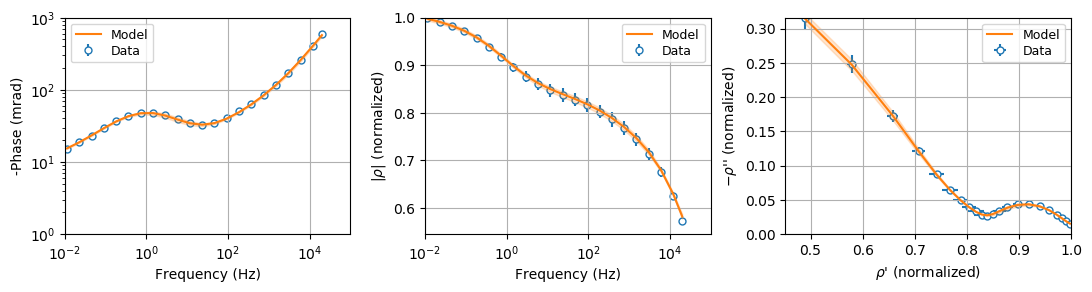

In [15]:
# Plot the precise data
stoc_ccd_obj.plot_fit()

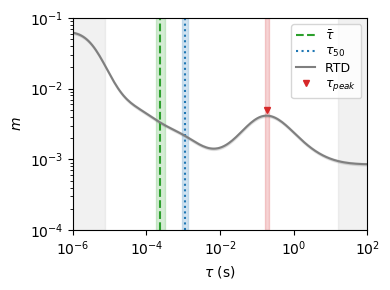

In [16]:
# Plot the RTD
stoc_ccd_obj.plot_rtd()
# Note how the recovered parameters are well-defined with narrow 95% HPD intervals

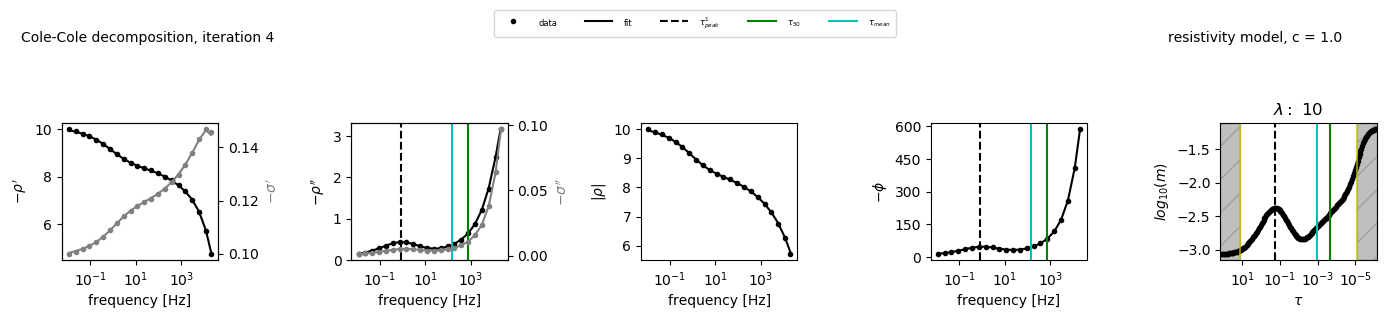

In [17]:
# Compare with CCD tools RTD
last_it.plot()

In [18]:
# Compare the tau_50 parameter obtained with ccd_tools with the
print("CCDtools tau_50:", last_it.stat_pars["tau_50"][0])
print("BISIP tau_50:", stoc_ccd_obj.MDL.trace("log_half_tau")[2000:].mean())
print("")
print("CCDtools tau_mean:", last_it.stat_pars["tau_mean"][0])
print("BISIP tau_mean:", stoc_ccd_obj.MDL.trace("log_mean_tau")[2000:].mean())
print("")
print("CCDtools R0:", last_it.stat_pars["rho0"][0])
print("BISIP R0:", stoc_ccd_obj.MDL.trace("R0")[2000:].mean())

CCDtools tau_50: -3.67701670196
BISIP tau_50: -3.62673526357

CCDtools tau_mean: -2.95308173412
BISIP tau_mean: -2.95339385635

CCDtools R0: 1.00688988821
BISIP R0: 1.01720591384


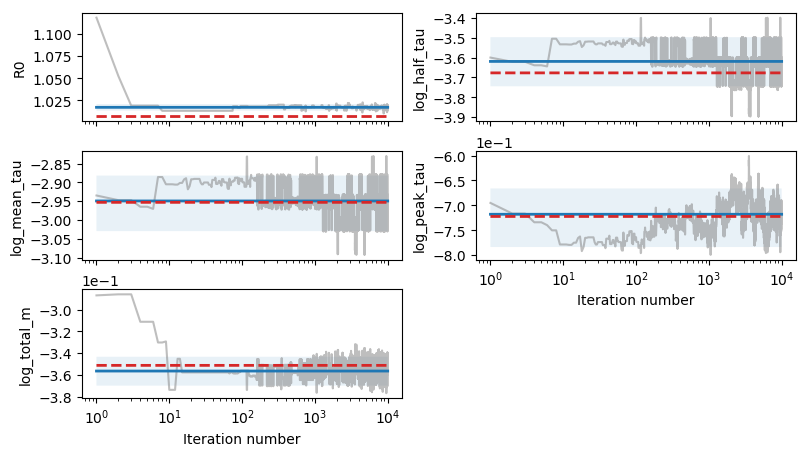

In [19]:
# Because nb_burn-in = 0 was used we can see the chain from the beginning
# The results should only be sampled in the region past 2000 iterations
stoc_ccd_obj.plot_traces()
# The shaded blue area is the 95% highest probability density interval
# The dashed red line is the result from CCD_tools
# The full blue line is the mean value of the MCMC chain

# It is possible to start the chain at the value obtained from CCD_tools
# However this implies that the noise is initially assumed to be 0%
# Which is obviously not the case as seen in the figure